# Build Python Environment

In [40]:
import bumps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty
from bumps.bounds import BoundedNormal

In [41]:
import scipy
from scipy.optimize import root_scalar
from scipy.optimize import root
from scipy.stats.mstats import mquantiles
import scipy.io
import pandas as pd

import io, os, sys, types
matplotlib_style = 'seaborn-whitegrid' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']

import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res
from datetime import datetime
    

import numpy as np
import numpy.matlib

import time

In [42]:
import subprocess
import glob
import h5py

In [74]:
#Location to save the log Files to
save_directory = 'directory/example/'


# Load Example Data

In [44]:
#For the simulation we'll use an example data file as a baseline to modify for the simulated magnetic peak
data = np.loadtxt('HB2C_531825.xye')

x = data[:,0]
y = data[:,1]
error = np.sqrt(y/100)

(20.0, 24.0)

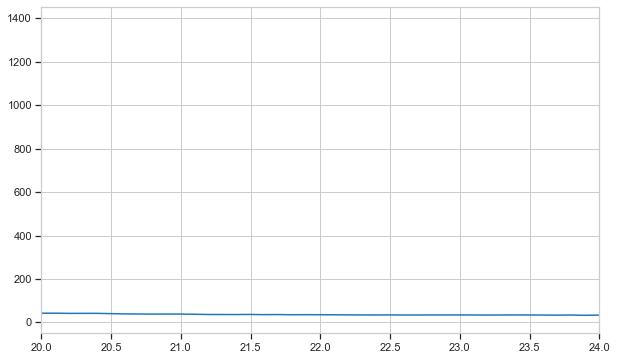

In [45]:
plt.plot(x,y)
plt.xlim(20,24)
# plt.ylim(0,50)

# Build Model Functions

In [46]:
# Isothermal Functions:

def Gaussian(x, alpha):
    #Gaussian peak centered at 0, evaluated at x, with HWHM alpha
    sigma = alpha/(np.sqrt(2.0 * np.log(2)))
    G = (1/(sigma*np.sqrt(2.0* np.pi)))*np.exp(-(x**2.0)/(2.0*sigma**2.0))
    return G

def Lorentzian(x, gamma):
    #Return Lorentzian peak centered at 0, evaluated at x, with HWHM gamma    
    L = gamma/(np.pi*(x**2.0 + gamma**2.0))
    return L

def Pseudo_voigt(x, alpha, gamma):
  f_L = 2.0*gamma
  f_G = 2.0*alpha

  f = (f_G**5.0\
       + 2.69269*(f_G**4.0)*(f_L)\
       + 2.42843*(f_G**3.0)*(f_L**2.0)\
       + 4.47163*(f_G**2.0)*(f_L**3.0)\
       + 0.07842*(f_G)*(f_L**4.0)\
       + f_L**5.0)**(0.2)

  eta = 1.36603*(f_L/f) - 0.477*(f_L/f)**2.0 + 0.11116*(f_L/f)**3.0

  hwhm = f/2.0
  
  PV = eta*Lorentzian(x,hwhm) + (1.0-eta)*Gaussian(x, hwhm)
  return PV

def One_peak(x, alpha, gamma, peak, scale, back):
    #Alpha, gamma, peak, scale, back are all row vectors
    #x is a collum vector of the positions
    two_thetas = np.add(x, -peak)
    PV = Pseudo_voigt(two_thetas, alpha, gamma)
    scaled_PV = PV*scale
    I = scaled_PV + back
    return I

def Two_peak(x, alpha, gamma, peak, scale, alpha1, gamma1, peak1, scale1, back):
    #Alpha, gamma, peak, scale, back are all row vectors
    #x is a collum vector of the positions
    I1 = One_peak(x, alpha, gamma, peak, scale, 0.0)
    I2 = One_peak(x, alpha1, gamma1, peak1, scale1, 0.0)
    I = I1 + I2 + back
    return I

####################################################
# Thermal Functions:

# Define I vs. T for first order phase transition:
def first_order_I_vs_T(temperatures, TN, Sigma, K, BK):
    I = ((K/2)*(1 - scipy.special.erf((temperatures - TN)/(np.sqrt(2.0)*Sigma))))**2 + BK
    return I



# Define the Brillouin Function
def Brillouin_J(x, J):
    # x is a matrix
    # J is a row-vector
    
    f1 = (2*J+1)/(2*J) #factor 1
    f2 = 1/(2*J) #factor 2
    B_J = f1/(np.tanh(f1*x)) - f2/(np.tanh(f2*x))
    return B_J
                   
# Define the Wiess equation (re-arranged so that it always = 0)                  
def Wiess(t, m, J):
    # t is a collum vector
    # J is a row vector
    # m is a matrix
    
    f1 = 3.0*J/(J +1.0) # factor 1
    f2 = 1.0/t #factor 2
    
    m = np.ones_like(t)*m
    x = f1*m*f2
    
    
    W = m - Brillouin_J(x, J)
    return W.reshape(-1)

#Define a Magnetization Solver for givin t and J:
def Mag_solve(t, J):
    # t is a collum vector
    # J is a row vector
    
    def fun(x):
        x= x.reshape((t.shape[0], J.shape[1]))
        return Wiess(t, x, J)
    
    X0 = np.ones((t.shape[0], J.shape[1]), dtype=np.float64) # matrix of every t,J combination
    
    solution = root(fun, X0, method ='hybr')
    
    m = np.array(solution.x).reshape((t.shape[0], J.shape[1]))
    return m

#Define the Intensity as function of Temperature for Second order phase transitions
def second_order_I_vs_T(Temperatures, TN, M0, J, BK):
    # TN, M0, J, BK are row vectors
    TN = np.array(TN).reshape(1,-1)
    M0 = np.array(M0).reshape(1,-1)
    J = np.array(J).reshape(1,-1)
    BK = np.array(BK).reshape(1,-1)
    # Temperatures is a collumn vector
    Temperatures = Temperatures.reshape(-1,1)
    
    Inverse_TN = 1/TN
    
    t = Temperatures @ Inverse_TN #Create a matrix of every (temperature, TN) combination

    #Find where all the temperatures below the TN. 
    t_low_truth = t <1.0
    t_low_truth = t_low_truth.reshape(t.shape)
    t_low = t*t_low_truth
    
    #Because "Mag_solve" is expensive, only pass the non-zero rows of the t_low matrix.
    t_low_cut = t_low[t_low.sum(axis=1) !=0] 

    #Calculate the reduced magnetization for below Tn\
    m_low = Mag_solve(t_low_cut, J) #returns a matrix where each collumn of m is associated with a collum of J
    
    #The mag is zero above the TN, construct that matrix
    m_high = np.zeros((t.shape[0]-t_low_cut.shape[0], t.shape[1]))
    #Combine the m matrixies for below and above the TN
    m = np.concatenate((m_low,m_high), axis=0)
    
    #"t_low_cut" could have a raggid bottom edge, so only keep the m values below the TN 
    m = m*t_low_truth

    #Calcualte the Magnetization (not reduced)
    M = m * M0 #row by row mulitplication of m by M0
    
    ##Calculate the intensities
    #Square of Magnetization
    I = M**2 
    
    #Add the background
    I = I + BK

    return I



####################################################
# Combine isothermal and thermal functions

def One_mag_peak(x, Temperatures, order, alpha, gamma, peak, scale, back, TN, J, sigma):
    #Alpha, gamma, peak, scale, back are all row vectors
    #x is a collum vector of the positions
    two_thetas = np.add(x, -peak)
    PV = Pseudo_voigt(two_thetas, alpha, gamma)
    
    if order == 2:
        #Calculate the scaling due the reduced magnetization vs Temp. 
        i = second_order_I_vs_T(Temperatures, TN, 1.0, J, 0.0)
    
    else:
        #Calculate the scaling due the reduced magnetization vs Temp. 
        i = first_order_I_vs_T(Temperatures, TN, sigma, 1.0, 0.0)
        
        
    #Multiply by the scale factor, and the reduced mag factor
    scaled_PV = PV*scale*i.T
    I = scaled_PV + back
    return I



def simulated_measurement(temperatures, order=2):
    #Simulated magnetic peak shape parameters
    sim_alpha = np.array(0.25).reshape(1,-1)
    sim_gamma = np.array(0.25).reshape(1,-1)
    sim_peak  = np.array(23.45).reshape(1,-1)
    sim_scale = np.array(45.0).reshape(1,-1)
    sim_back  = np.array(0).reshape(1,-1) #must be zero because we add this peak to the real data set.
    
    #Simulated Structural peak parameters
    sim_alpha_1 = np.array(0.25).reshape(1,-1)
    sim_gamma_1 = np.array(0.25).reshape(1,-1)
    sim_peak_1 = np.array(21.25).reshape(1,-1)
    sim_scale_1 = np.array(20.0).reshape(1,-1)
    
    #Simulated magnetic parameters
    #Simulated Transition temperature
    sim_tn = np.array(35.0).reshape(1,-1)
    
    #For order = 2, Simulated total angular momentum
    sim_j = np.array(0.5).reshape(1,-1)
    #For order = 1, Simulated transistion width
    sim_sigma = np.array(1.75).reshape(1,-1)
    
    diffraction_space = np.array(x).reshape(-1,1)
    
    noiseless_peak = One_mag_peak(diffraction_space, temperatures, order,
                                  sim_alpha, sim_gamma, sim_peak, sim_scale, sim_back, 
                                  sim_tn, sim_j, sim_sigma)
    noisy_peak = np.random.normal(loc = noiseless_peak,
                         scale = np.sqrt(noiseless_peak/100))
    
    structural_peak = One_peak(diffraction_space, sim_alpha_1, sim_gamma_1, sim_peak_1, sim_scale_1, sim_back)
    structural_peak = np.random.normal(loc = structural_peak,
                         scale = np.sqrt(structural_peak/100))
    
    #Add the simulated peak to the set of real data
    sim_data = np.array(y).reshape(-1,1) + noisy_peak + structural_peak
    
    #Add the simulated error to the real data error
    sim_error = np.sqrt(sim_data/100)

    return diffraction_space, sim_data, sim_error


(0.0, 100.0)

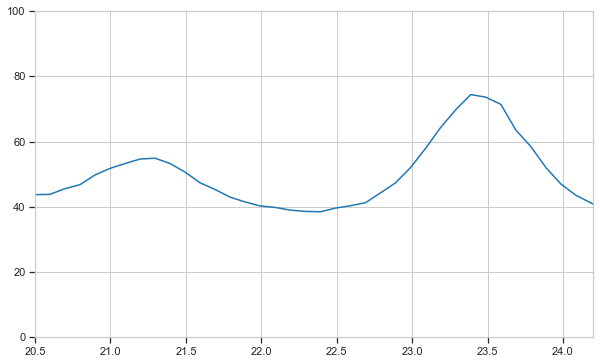

In [47]:
#Let's look at a simulated measurement at some temperature:
two_theta, I, I_error = simulated_measurement(np.array(5))

plt.figure(figsize(10,6))
plt.plot(two_theta, I)
plt.xlim(20.5,24.2)
plt.ylim(0,100)

# Build the Instrument Control Tools

The definitions of the <code>change_temperature</code> and <code>count_two_theta</code> functions under the <code>Simulation == False</code> braches are instrument specific means of communicating the change temperature and count commands to the instrument and recieving the diffraction pattern data. If <code>Simulation</code> is set to <code>False</code> currently the notebook will give an error because it is not connected to the instrument. 

The <code>Simulation == True</code> branches use the example data file loaded above. 

In [48]:
#Directories on Instrument LIMS where data is stored
nexus_folder = '/HFIR/HB2C/IPTS-27176/nexus/'
reduced_folder = '/HFIR/HB2C/IPTS-27176/shared/autoreduce/'

In [49]:
def change_temperature(Temperature, count_time=300, Simulation = False):
    if Simulation == False:
        
        # set temperature and measure run
        Temperature = Temperature[0]
        
        #Instrument specific location of set_temp.py
        cmd = f'/bin/python /HFIR/HB2C/IPTS-27176/shared/set_temp.py {Temperature} {count_time}'   
        proc = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE,stdout=subprocess.PIPE,
                                stderr=subprocess.PIPE,
                                universal_newlines = True)
        #outs, errs = proc.communicate()
        #print(outs, errs)
        proc.wait()
        print("set point: %s" % Temperature)
        # wait a few seconds, to make sure we have the run saved
        time.sleep(20)
        # get the latest file
        datafiles = glob.glob(nexus_folder+'*.h5')
        latest = max(datafiles,key=os.path.getmtime)
        # get temperature and processed file name
        with h5py.File(latest, "r") as f:
            temperature_reading = f['/entry/DASlogs/HB2C:SE:SampleTemp/average_value'][0]
            temperature_reading = np.array(temperature_reading).reshape(-1,1)
            run_number = f['/entry/run_number'][0].decode("utf-8")
            expected_file = f'{reduced_folder}HB2C_{run_number}.xye'
    else:
        temperature_reading = Temperature
        expected_file = Temperature.reshape(-1,1)
    return temperature_reading, expected_file

In [50]:
def count_two_theta(expected_file, Simulation = False):
    error_measurement = None
    if Simulation == False:
        while not os.path.isfile(expected_file):
            time.sleep(10)
        Measured_two_theta, intensity_measurement, error_measurement = np.loadtxt(expected_file, unpack=True)
        Measured_two_theta = np.array(Measured_two_theta).reshape(-1,1)
        intensity_measurement = np.array(intensity_measurement).reshape(-1,1)
        error_measurement = np.array(error_measurement).reshape(-1,1)
    else:
        Temperature = expected_file
        Measured_two_theta, intensity_measurement, error_measurement = simulated_measurement(Temperature, order = 2)
    
    return Measured_two_theta, intensity_measurement, error_measurement 

# Build AI Models

## Diffraction Space Models

In [51]:
def Isothermal_one_peak_model(X_grid, Y_grid, E_grid):
    M = Curve(One_peak, X_grid, Y_grid,
             dy = E_grid,
             alpha = Alpha_1_guess, gamma = Gamma_1_guess, peak = Peak_1_guess, scale = Scale_1_guess,
             back = Back_guess)
    
    #Structural Peak Parameters
    M.alpha.bounds = Alpha_1_dist
    M.gamma.bounds = Gamma_1_dist
    M.peak.bounds = Peak_1_dist
    M.scale.bounds = Scale_1_dist
    M.back.bounds = Back_dist
    
    problem = FitProblem(M)
    return problem

def Isothermal_two_peak_model(X_grid, Y_grid, E_grid):
    M = Curve(Two_peak, X_grid, Y_grid,
             dy = E_grid,
             alpha = Alpha_guess, gamma = Gamma_guess, peak = Peak_guess,
             alpha1 = Alpha_1_guess, gamma1 = Gamma_1_guess, peak1 = Peak_1_guess, 
             back = Back_guess )
    
    #Magnetic Peak Parameters
    M.alpha.bounds = Alpha_dist
    M.gamma.bounds = Gamma_dist
    M.peak.bounds = Peak_dist
    M.scale.bounds = Scale_dist
    
    #Structural Peak Parameters
    M.alpha1.bounds = Alpha_1_dist
    M.gamma1.bounds = Gamma_1_dist
    M.peak1.bounds = Peak_1_dist
    M.scale1.bounds = Scale_1_dist
    
    M.back.bounds = Back_dist
    
    problem = FitProblem(M)
    return problem


In [52]:
def Iso_thermal_one_peak_inference_train(X_grid, Y_grid, E_grid):
    problem = Isothermal_one_peak_model(X_grid, Y_grid, E_grid)
    
    method = 'dream' 
    
    print("initial chisq", problem.chisq_str())
    result = fit(problem, method=method, xtol=1e-6, ftol=1e-8, 
                 samples = 100000, 
                 burn = 100,
                 pop = 10,
                 init = 'eps',
                 thin = 1,
                 alpha = 0.1,
                 outliers = 'none',
                 trim = False,
                 steps = 0)
    print("final chisq", problem.chisq_str())
    for k, v, dv in zip(problem.labels(), result.x, result.dx):
        print(k, ":", format_uncertainty(v, dv))
        
    return problem, result

def Iso_thermal_two_peak_inference_train(X_grid, Y_grid, E_grid):
    problem = Isothermal_two_peak_model(X_grid, Y_grid, E_grid)
    
    method = 'dream' 
    
    print("initial chisq", problem.chisq_str())
    result = fit(problem, method=method, xtol=1e-6, ftol=1e-8, 
                 samples = 100000, 
                 burn = 100,
                 pop = 10,
                 init = 'eps',
                 thin = 1,
                 alpha = 0.1,
                 outliers = 'none',
                 trim = False,
                 steps = 0)
    print("final chisq", problem.chisq_str())
    for k, v, dv in zip(problem.labels(), result.x, result.dx):
        print(k, ":", format_uncertainty(v, dv))
        
    return problem, result

In [53]:
def Isothermal_one_peak_inference_predict(posterior_results, X_predict):
    #Extract the Posterior of the parameters
    draw = posterior_results.state.draw()
    
    #Posterior results are in alphabetical order
    Posterior_ALPHA = draw.points[:,0].reshape(1,-1)
    Posterior_GAMMA = draw.points[:,2].reshape(1,-1)
    Posterior_PEAK = draw.points[:,3].reshape(1,-1)
    Posterior_SCALE = draw.points[:,4].reshape(1,-1)
    Posterior_BACK = draw.points[:,1].reshape(1,-1)

    #Calcualte the mean of the parameters
    ALPHA_mean = np.mean(Posterior_ALPHA).reshape(1,-1)
    GAMMA_mean = np.mean(Posterior_GAMMA).reshape(1,-1)
    PEAK_mean = np.mean(Posterior_PEAK).reshape(1,-1)
    SCALE_mean = np.mean(Posterior_SCALE).reshape(1,-1)
    BACK_mean = np.mean(Posterior_BACK).reshape(1,-1)
    
    #Calculate the curve from the mean of the parameters
    Isothermal_Mean_Posterior_parameter_curve = One_peak(X_predict, ALPHA_mean, GAMMA_mean, PEAK_mean, SCALE_mean, BACK_mean)
    
    #Calculate the curve from the BEST parameters
    Alpha_best = posterior_results.state.best()[0][0]
    Gamma_best = posterior_results.state.best()[0][2]
    Peak_best = posterior_results.state.best()[0][3]
    Scale_best = posterior_results.state.best()[0][4]
    Back_best = posterior_results.state.best()[0][1]
    Isothermal_best_curve = One_peak(X_predict, Alpha_best, Gamma_best, Peak_best, Scale_best, Back_best)
    
    
    #Calculate the predicted curves by iterating through the posterior sets of parameters
    print('Predicting')
    Isothermal_CI_curves = One_peak(X_predict, Posterior_ALPHA, Posterior_GAMMA, Posterior_PEAK, Posterior_SCALE, Posterior_BACK)
        
    q = np.array([0.95, 0.05])
    I_ci = np.quantile(Isothermal_CI_curves, q, axis=1)#.reshape((-1,2))
    Isothermal_lower_curve = I_ci[1,:].reshape(-1,1)
    Isothermal_upper_curve = I_ci[0,:].reshape(-1,1)
    
    Isothermal_mean_of_posterior_curves = np.mean(Isothermal_CI_curves, axis=1).reshape(-1,1)
        
    dictionary = {'ALPHA Mean':ALPHA_mean,
                  'GAMMA Mean':GAMMA_mean,
                  'PEAK Mean':PEAK_mean,
                  'SCALE Mean':SCALE_mean, 
                  'BACK Mean':BACK_mean,
                  'Isothermal Mean Posterior Parameter Curve': Isothermal_Mean_Posterior_parameter_curve,
                  'Isothermal Best Parameter Curve':  Isothermal_best_curve,
                  'Isothermal Mean of Posterior Curves': Isothermal_mean_of_posterior_curves,
                  'Isothermal Variance': Isothermal_variance,
                  'Isothermal CI Curves': Isothermal_CI_curves,
                  'Isothermal lower Curve': Isothermal_lower_curve,
                  'Isothermal upper Curve': Isothermal_upper_curve}
    
    return dictionary


In [54]:
def Isothermal_two_peak_inference_predict(posterior_results, X_predict):
    #Extract the Posterior of the parameters
    draw = posterior_results.state.draw()
    
    #Posterior results are in alphabetical order
    Posterior_ALPHA = draw.points[:,0].reshape(1,-1)
    Posterior_GAMMA = draw.points[:,3].reshape(1,-1)
    Posterior_PEAK = draw.points[:,5].reshape(1,-1)
    Posterior_SCALE = draw.points[:,7].reshape(1,-1)
    
    Posterior_ALPHA_1 = draw.points[:,1].reshape(1,-1)
    Posterior_GAMMA_1 = draw.points[:,4].reshape(1,-1)
    Posterior_PEAK_1 = draw.points[:,6].reshape(1,-1)
    Posterior_SCALE_1 = draw.points[:,8].reshape(1,-1)
    
    Posterior_BACK = draw.points[:,2].reshape(1,-1)

    #Calcualte the mean of the parameters
    ALPHA_mean = np.mean(Posterior_ALPHA).reshape(1,-1)
    GAMMA_mean = np.mean(Posterior_GAMMA).reshape(1,-1)
    PEAK_mean = np.mean(Posterior_PEAK).reshape(1,-1)
    SCALE_mean = np.mean(Posterior_SCALE).reshape(1,-1)
    
    ALPHA_1_mean = np.mean(Posterior_ALPHA_1).reshape(1,-1)
    GAMMA_1_mean = np.mean(Posterior_GAMMA_1).reshape(1,-1)
    PEAK_1_mean = np.mean(Posterior_PEAK_1).reshape(1,-1)
    SCALE_1_mean = np.mean(Posterior_SCALE_1).reshape(1,-1)
    
    BACK_mean = np.mean(Posterior_BACK).reshape(1,-1)
    
    #Calculate the curve from the mean of the parameters
    Isothermal_Mean_Posterior_parameter_curve = Two_peak(X_predict,
                                                         ALPHA_mean, GAMMA_mean, PEAK_mean, SCALE_mean,
                                                         ALPHA_1_mean, GAMMA_1_mean, PEAK_1_mean, SCALE_1_mean,
                                                         BACK_mean)
    
    
    #Posterior results are in alphabetical order
    ALPHA_best = posterior_results.state.best()[0][0]
    GAMMA_best = posterior_results.state.best()[0][3]
    PEAK_best = posterior_results.state.best()[0][5]
    SCALE_best = posterior_results.state.best()[0][7]
    
    ALPHA_1_best = posterior_results.state.best()[0][1]
    GAMMA_1_best = posterior_results.state.best()[0][4]
    PEAK_1_best = posterior_results.state.best()[0][6]
    SCALE_1_best = posterior_results.state.best()[0][8]
    
    BACK_best = posterior_results.state.best()[0][2]
    #Calculate the curve from the BEST parameters
    Isothermal_best_curve = Two_peak(X_predict,
                                     ALPHA_best, GAMMA_best, PEAK_best, SCALE_best,
                                     ALPHA_1_best, GAMMA_1_best, PEAK_1_best, SCALE_1_best,
                                     BACK_best)
    
    #Calculate the predicted curves by iterating through the posterior sets of parameters
    print('Predicting')
    Isothermal_CI_curves = Two_peak(X_predict,
                                    Posterior_ALPHA, Posterior_GAMMA, Posterior_PEAK, Posterior_SCALE,
                                    Posterior_ALPHA_1, Posterior_GAMMA_1, Posterior_PEAK_1, Posterior_SCALE_1,
                                    Posterior_BACK)
        
    q = np.array([0.95, 0.05])
    I_ci = np.quantile(Isothermal_CI_curves, q, axis=1)#.reshape((-1,2))
    Isothermal_lower_curve = I_ci[1,:].reshape(-1,1)
    Isothermal_upper_curve = I_ci[0,:].reshape(-1,1)
    
    Isothermal_mean_of_posterior_curves = np.mean(Isothermal_CI_curves, axis=1).reshape(-1,1)
    Isothermal_variance = np.var(Isothermal_CI_curves, axis=1).reshape(-1,1)
    
    ########## Find the maximum intensity of the magnetic peak ##############
    #If it is true that the magnetic is always at Higher 2theta:
    if PEAK_mean > PEAK_1_mean:
        Magnetic_peak_max_intensities = One_peak(np.array(0.0).reshape(-1,1),
                                                 Posterior_ALPHA,
                                                 Posterior_GAMMA,
                                                 np.array(0.0).reshape(1,-1),
                                                 Posterior_SCALE,
                                                 Posterior_BACK)

        Mag_peak_CI_curves = One_peak(X_predict,
                                      Posterior_ALPHA,
                                      Posterior_GAMMA,
                                      Posterior_PEAK,
                                      Posterior_SCALE,
                                      Posterior_BACK)

        Struct_peak_max_intensities = One_peak(np.array(0.0).reshape(-1,1),
                                               Posterior_ALPHA_1,
                                               Posterior_GAMMA_1,
                                               np.array(0.0).reshape(1,-1),
                                               Posterior_SCALE_1,
                                               Posterior_BACK)

    else:
        Magnetic_peak_max_intensities = One_peak(np.array(0.0).reshape(-1,1),
                                                 Posterior_ALPHA_1,
                                                 Posterior_GAMMA_1,
                                                 np.array(0.0).reshape(1,-1),
                                                 Posterior_SCALE_1,
                                                 Posterior_BACK)

        Mag_peak_CI_curves = One_peak(X_predict,
                                      Posterior_ALPHA_1,
                                      Posterior_GAMMA_1,
                                      Posterior_PEAK_1,
                                      Posterior_SCALE_1,
                                      Posterior_BACK)
        
        Struct_peak_max_intensities = One_peak(np.array(0.0).reshape(-1,1),
                                               Posterior_ALPHA,
                                               Posterior_GAMMA,
                                               np.array(0.0).reshape(1,-1),
                                               Posterior_SCALE,
                                               Posterior_BACK)
        print('Did the peaks swap!?')
    
    Mag_ci = np.quantile(Mag_peak_CI_curves, q, axis=1)#.reshape((-1,2))
    Mag_lower_curve = Mag_ci[1,:].reshape(-1,1)
    Mag_upper_curve = Mag_ci[0,:].reshape(-1,1)
    
    Mag_mean_of_posterior_curves = np.mean(Mag_peak_CI_curves, axis=1).reshape(-1,1)
    Mag_variance_curve = np.var(Mag_peak_CI_curves, axis=1).reshape(-1,1)
    
    dictionary = {'ALPHA Mean':ALPHA_mean, 
                  'GAMMA Mean':GAMMA_mean, 
                  'PEAK Mean':PEAK_mean, 
                  'SCALE Mean':SCALE_mean, 
                  'ALPHA_1 Mean':ALPHA_1_mean,  
                  'GAMMA_1 Mean':GAMMA_1_mean, 
                  'PEAK_1 Mean':PEAK_1_mean, 
                  'SCALE_1 Mean':SCALE_1_mean, 
                  'BACK Mean':BACK_mean, 
                  'Isothermal Mean Posterior Parameter Curve': Isothermal_Mean_Posterior_parameter_curve,
                  'Isothermal Best Parameter Curve':  Isothermal_best_curve,
                  'Isothermal Mean of Posterior Curves': Isothermal_mean_of_posterior_curves,
                  'Isothermal Variance': Isothermal_variance,
                  'Isothermal CI Curves': Isothermal_CI_curves,
                  'Isothermal lower Curve': Isothermal_lower_curve,
                  'Isothermal upper Curve': Isothermal_upper_curve,
                  'Magnetic Peak Max Intensities': Magnetic_peak_max_intensities,
                  'Mag Peak CI Curves': Mag_peak_CI_curves,
                  'Mag Peak Upper Curve': Mag_upper_curve ,
                  'Mag Peak Lower Curve': Mag_lower_curve,
                  'Mean of Mag Peak Curves':Mag_mean_of_posterior_curves,
                  'Variance of Mag Peak Curves': Mag_variance_curve,
                  'Structural Peak Max Intensities': Struct_peak_max_intensities}
    
    return dictionary


In [55]:
def Bayes_factor(Two_peak_posterior_results, One_peak_posterior_results):
    Two_peak_loglikelihood = Two_peak_posterior_results.state.best()[1]
    
    One_peak_loglikelihood = One_peak_posterior_results.state.best()[1]
    
    return One_peak_loglikelihood, Two_peak_loglikelihood

In [56]:
def update_isothermal_dataframe(dataframe, index, temperature, posterior_model, posterior_results, posterior_predictions,
                               One_peak_loglikelihood, Two_peak_loglikelihood):
    #Cycle Identifying
    dataframe.loc[index, 'Isothermal Cycle'] = index
    dataframe.loc[index, 'Temperature'] = temperature
    
    #Likelihoods
    dataframe.loc[index, 'One peak loglikelihood'] = One_peak_loglikelihood
    dataframe.loc[index, 'Two peak loglikelihood'] = Two_peak_loglikelihood
    
    #Input data
    dataframe.loc[index, 'Measured 2Theta'] = posterior_model.fitness.x
    dataframe.loc[index, 'Measured I'] = posterior_model.fitness.y
    dataframe.loc[index, 'Measured I error'] = posterior_model.fitness.dy

    #Posterior Parameters
    draw = posterior_results.state.draw()
    
    dataframe.loc[index, 'Posterior Alpha'] = draw.points[:,0].reshape(1,-1)
    dataframe.loc[index, 'Posterior Gamma'] = draw.points[:,3].reshape(1,-1)
    dataframe.loc[index, 'Posterior Peak'] = draw.points[:,5].reshape(1,-1)
    dataframe.loc[index, 'Posterior Scale'] = draw.points[:,7].reshape(1,-1)
    
    dataframe.loc[index, 'Posterior Alpha_1'] = draw.points[:,1].reshape(1,-1)
    dataframe.loc[index, 'Posterior Gamma_1'] = draw.points[:,4].reshape(1,-1)
    dataframe.loc[index, 'Posterior Peak_1'] = draw.points[:,6].reshape(1,-1)
    dataframe.loc[index, 'Posterior Scale_1'] = draw.points[:,8].reshape(1,-1)
    
    dataframe.loc[index, 'Posterior Back'] = draw.points[:,2].reshape(1,-1)

    dataframe.loc[index, 'Best Alpha'] = posterior_results.state.best()[0][0]
    dataframe.loc[index, 'Best Gamma'] = posterior_results.state.best()[0][3]
    dataframe.loc[index, 'Best Peak'] = posterior_results.state.best()[0][5]
    dataframe.loc[index, 'Best Scale'] = posterior_results.state.best()[0][7]
    
    dataframe.loc[index, 'Best Alpha_1'] = posterior_results.state.best()[0][1]
    dataframe.loc[index, 'Best Gamma_1'] = posterior_results.state.best()[0][4]
    dataframe.loc[index, 'Best Peak_1'] = posterior_results.state.best()[0][6]
    dataframe.loc[index, 'Best Scale_1'] = posterior_results.state.best()[0][8]
    
    dataframe.loc[index, 'Best Back'] = posterior_results.state.best()[0][2]
    
    dataframe.loc[index, 'Alpha Std'] = posterior_results.dx[0]
    dataframe.loc[index, 'Gamma Std'] = posterior_results.dx[3]
    dataframe.loc[index, 'Peak Std'] = posterior_results.dx[5]
    dataframe.loc[index, 'Scale Std'] = posterior_results.dx[7]
    
    dataframe.loc[index, 'Alpha_1 Std'] = posterior_results.dx[1]
    dataframe.loc[index, 'Gamma_1 Std'] = posterior_results.dx[4]
    dataframe.loc[index, 'Peak_1 Std'] = posterior_results.dx[6]
    dataframe.loc[index, 'Scale_1 Std'] = posterior_results.dx[8]
    
    dataframe.loc[index, 'Back Std'] = posterior_results.dx[2]
    
    #Predictions
    dataframe.loc[index, 'Mean Parameter Curve'] = posterior_predictions['Isothermal Mean Posterior Parameter Curve']
    dataframe.loc[index, 'Best Parameters Curve'] = posterior_predictions['Isothermal Best Parameter Curve']
    dataframe.loc[index, 'Mean of Posterior Curves'] = posterior_predictions['Isothermal Mean of Posterior Curves']
    dataframe.loc[index, 'Variance'] = posterior_predictions['Isothermal Variance']
    dataframe.loc[index, 'Confidence Interval Curves'] = posterior_predictions['Isothermal CI Curves']
    dataframe.loc[index, 'Lower Bound'] = posterior_predictions['Isothermal lower Curve']
    dataframe.loc[index, 'Upper Bound'] = posterior_predictions['Isothermal upper Curve']
    #Magnetic Max Intensity Distribution
    dataframe.loc[index, 'Magnetic Max Intensity Distribution'] = posterior_predictions['Magnetic Peak Max Intensities']
    dataframe.loc[index, 'Magnetic Confidence Interval Curves'] = posterior_predictions['Mag Peak CI Curves']
    dataframe.loc[index, 'Magnetic Upper Bound'] = posterior_predictions['Mag Peak Upper Curve']
    dataframe.loc[index, 'Magnetic Lower Bound'] = posterior_predictions['Mag Peak Lower Curve']
    dataframe.loc[index, 'Mean of Mag Peak Curves'] = posterior_predictions['Mean of Mag Peak Curves']
    dataframe.loc[index, 'Variance of Mag Peak Curves'] = posterior_predictions['Variance of Mag Peak Curves']
    #Structural Peak Intensity Distribution
    dataframe.loc[index, 'Structural Max Intensity Distribution'] = posterior_predictions['Structural Peak Max Intensities']
    
    return dataframe

In [57]:
def update_isothermal_one_peak_dataframe(dataframe, index, temperature, posterior_model, posterior_results, posterior_predictions):
    #Cycle Identifying
    dataframe.loc[index, 'Isothermal Cycle'] = index
    dataframe.loc[index, 'Temperature'] = temperature
    
    #Input data
    dataframe.loc[index, 'Measured 2Theta'] = posterior_model.fitness.x
    dataframe.loc[index, 'Measured I'] = posterior_model.fitness.y
    dataframe.loc[index, 'Measured I error'] = posterior_model.fitness.dy

    #Posterior Parameters
    draw = posterior_results.state.draw()
    
    dataframe.loc[index, 'Posterior Alpha'] = draw.points[:,0].reshape(1,-1)
    dataframe.loc[index, 'Posterior Gamma'] = draw.points[:,2].reshape(1,-1)
    dataframe.loc[index, 'Posterior Peak'] = draw.points[:,3].reshape(1,-1)
    dataframe.loc[index, 'Posterior Scale'] = draw.points[:,4].reshape(1,-1)
    
    dataframe.loc[index, 'Posterior Back'] = draw.points[:,1].reshape(1,-1)
    
    dataframe.loc[index, 'Best Alpha'] = posterior_results.state.best()[0][0]
    dataframe.loc[index, 'Best Gamma'] = posterior_results.state.best()[0][2]
    dataframe.loc[index, 'Best Peak'] = posterior_results.state.best()[0][3]
    dataframe.loc[index, 'Best Scale'] = posterior_results.state.best()[0][4]
    
    dataframe.loc[index, 'Best Back'] = posterior_results.state.best()[0][1]
    
    dataframe.loc[index, 'Alpha Std'] = posterior_results.dx[0]
    dataframe.loc[index, 'Gamma Std'] = posterior_results.dx[2]
    dataframe.loc[index, 'Peak Std'] = posterior_results.dx[3]
    dataframe.loc[index, 'Scale Std'] = posterior_results.dx[4]
    
    dataframe.loc[index, 'Back Std'] = posterior_results.dx[1]

    #Predictions
    dataframe.loc[index, 'Mean Parameter Curve'] = posterior_predictions['Isothermal Mean Posterior Parameter Curve']
    dataframe.loc[index, 'Best Parameters Curve'] = posterior_predictions['Isothermal Best Parameter Curve']
    dataframe.loc[index, 'Mean of Posterior Curves'] = posterior_predictions['Isothermal Mean of Posterior Curves']
    dataframe.loc[index, 'Variance'] = posterior_predictions['Isothermal Variance']
    dataframe.loc[index, 'Confidence Interval Curves'] = posterior_predictions['Isothermal CI Curves']
    dataframe.loc[index, 'Lower Bound'] = posterior_predictions['Isothermal lower Curve']
    dataframe.loc[index, 'Upper Bound'] = posterior_predictions['Isothermal upper Curve']
    
    return dataframe

In [58]:
def plot_isothermal_inference(X_predict, posterior_predictions, posterior_model, dataframe, temperature, Hist = True):
    #For the Pedictive Curves
    Mean_of_parameters = posterior_predictions['Isothermal Mean Posterior Parameter Curve']
    Best_parameter_curve = posterior_predictions['Isothermal Best Parameter Curve']   
    Mean_of_posterior_curves = posterior_predictions['Isothermal Mean of Posterior Curves']
    Lower = posterior_predictions['Isothermal lower Curve']
    Upper = posterior_predictions['Isothermal upper Curve']
    Mag_Lower = posterior_predictions['Mag Peak Lower Curve']
    Mag_Upper = posterior_predictions['Mag Peak Upper Curve']
    
    Measured_2Theta = posterior_model.fitness.x.reshape(-1,1)
    Measured_I = posterior_model.fitness.y.reshape(-1,1)
    Measured_Ierror = posterior_model.fitness.dy.reshape(-1,1)
    
    plt.figure(figsize=(10,10))
    plt.title('Isothermal Predictions')
    plt.errorbar(Measured_2Theta.reshape(-1), Measured_I.reshape(-1), yerr = Measured_Ierror.reshape(-1), fmt= 'bo', label = 'Measured Data')
    plt.fill_between(X_predict.flatten(), Upper.flatten(), Lower.flatten(), alpha=0.7,color="#7A68A6", label = 'Cofidence Interval')
    plt.fill_between(X_predict.flatten(), Mag_Upper.flatten(), Mag_Lower.flatten(), alpha=0.7,color="#f6b26b", label = 'Mag Cofidence Interval')
    plt.plot(X_predict, Mean_of_posterior_curves, 'r-', linewidth=7.0, label = 'Mean of Posterior Curves')
    plt.plot(X_predict, Best_parameter_curve, 'k--', label = 'Best Parameters')
#     plt.plot(X_predict, Mean_of_parameters, 'k--', label = 'Mean of Parameters')
    plt.xlabel('2Theta (degrees)')
    plt.ylabel('Intensity (arb. units)')
    plt.legend()
    plt.show()
    
    if Hist == True:
        
        #The posterior distributions are not all the same size, so draw a set number of sampels from them. 
        hist_size=10000
        
        posterior_Alpha_distributions = np.empty((hist_size, 0))
        posterior_Gamma_distributions = np.empty((hist_size, 0))
        posterior_Peak_distributions = np.empty((hist_size, 0))
        posterior_Scale_distributions = np.empty((hist_size, 0))

        posterior_Alpha_1_distributions = np.empty((hist_size, 0))
        posterior_Gamma_1_distributions = np.empty((hist_size, 0))
        posterior_Peak_1_distributions = np.empty((hist_size, 0))
        posterior_Scale_1_distributions = np.empty((hist_size, 0))
        
        posterior_Back_distributions = np.empty((hist_size, 0))

        posterior_Mag_distributions = np.empty((hist_size, 0))
        
        for i, _ in enumerate(dataframe.index):
            temp_Alpha = np.random.choice(dataframe['Posterior Alpha'][i].flatten(), hist_size).reshape(-1,1)
            temp_Gamma = np.random.choice(dataframe['Posterior Gamma'][i].flatten(), hist_size).reshape(-1,1)
            temp_Peak = np.random.choice(dataframe['Posterior Peak'][i].flatten(), hist_size).reshape(-1,1)
            temp_Scale = np.random.choice(dataframe['Posterior Scale'][i].flatten(), hist_size).reshape(-1,1)
            
            temp_Alpha_1 = np.random.choice(dataframe['Posterior Alpha_1'][i].flatten(), hist_size).reshape(-1,1)
            temp_Gamma_1 = np.random.choice(dataframe['Posterior Gamma_1'][i].flatten(), hist_size).reshape(-1,1)
            temp_Peak_1 = np.random.choice(dataframe['Posterior Peak_1'][i].flatten(), hist_size).reshape(-1,1)
            temp_Scale_1 = np.random.choice(dataframe['Posterior Scale_1'][i].flatten(), hist_size).reshape(-1,1)

            temp_Back = np.random.choice(dataframe['Posterior Back'][i].flatten(), hist_size).reshape(-1,1)

            temp_Mag = np.random.choice(dataframe['Magnetic Max Intensity Distribution'][i].flatten(), hist_size).reshape(-1,1)

            
            posterior_Alpha_distributions = np.concatenate((posterior_Alpha_distributions, temp_Alpha), axis=1)
            posterior_Gamma_distributions = np.concatenate((posterior_Gamma_distributions, temp_Gamma), axis=1)
            posterior_Peak_distributions = np.concatenate((posterior_Peak_distributions, temp_Peak), axis=1)
            posterior_Scale_distributions = np.concatenate((posterior_Scale_distributions, temp_Scale), axis=1)

            posterior_Alpha_1_distributions = np.concatenate((posterior_Alpha_1_distributions, temp_Alpha_1), axis=1)
            posterior_Gamma_1_distributions = np.concatenate((posterior_Gamma_1_distributions, temp_Gamma_1), axis=1)
            posterior_Peak_1_distributions = np.concatenate((posterior_Peak_1_distributions, temp_Peak_1), axis=1)
            posterior_Scale_1_distributions = np.concatenate((posterior_Scale_1_distributions, temp_Scale_1), axis=1)

            posterior_Back_distributions = np.concatenate((posterior_Back_distributions, temp_Back), axis=1)

            posterior_Mag_distributions = np.concatenate((posterior_Mag_distributions, temp_Mag), axis=1)
      
        a = np.linspace(1,posterior_Peak_distributions.shape[1],posterior_Peak_distributions.shape[1])
        A = np.matlib.repmat(a, posterior_Peak_distributions.shape[0], 1)

        h0, Aedges, Alpha_edges = np.histogram2d(A.flatten(), posterior_Alpha_distributions.flatten(), bins=[A.shape[1], 256])
        h1, Aedges, Gamma_edges = np.histogram2d(A.flatten(), posterior_Gamma_distributions.flatten(), bins=[A.shape[1], 256])
        h2, Aedges, Peak_edges = np.histogram2d(A.flatten(), posterior_Peak_distributions.flatten(), bins=[A.shape[1], 256])
        h3, Aedges, Scale_edges = np.histogram2d(A.flatten(), posterior_Scale_distributions.flatten(), bins=[A.shape[1], 256])
        
        h4, Aedges, Alpha_1_edges = np.histogram2d(A.flatten(), posterior_Alpha_1_distributions.flatten(), bins=[A.shape[1], 256])
        h5, Aedges, Gamma_1_edges = np.histogram2d(A.flatten(), posterior_Gamma_1_distributions.flatten(), bins=[A.shape[1], 256])
        h6, Aedges, Peak_1_edges = np.histogram2d(A.flatten(), posterior_Peak_1_distributions.flatten(), bins=[A.shape[1], 256])
        h7, Aedges, Scale_1_edges = np.histogram2d(A.flatten(), posterior_Scale_1_distributions.flatten(), bins=[A.shape[1], 256])
        
        h8, Aedges, Back_edges = np.histogram2d(A.flatten(), posterior_Back_distributions.flatten(), bins=[A.shape[1], 256])

        h9, Aedges, Mag_edges = np.histogram2d(A.flatten(), posterior_Mag_distributions.flatten(), bins=[A.shape[1], 256])

        cmap = plt.cm.plasma#.copy()
        cmap.set_bad(cmap(0))
        
        plt.figure(figsize=(10,25))
        
        plt.subplot(5,2,1)
        plt.pcolormesh(Aedges, Alpha_edges, h0.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h0)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Alpha")
        
        plt.subplot(5,2,3)
        plt.pcolormesh(Aedges, Gamma_edges, h1.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h1)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Gamma")
        
        plt.subplot(5,2,5)
        plt.pcolormesh(Aedges, Peak_edges, h2.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h2)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Peak")
        
        plt.subplot(5,2,7)
        plt.pcolormesh(Aedges, Scale_edges, h3.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h3)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Scale")
        
        plt.subplot(5,2,2)
        plt.pcolormesh(Aedges, Alpha_1_edges, h4.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h4)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Alpha_1")
        
        plt.subplot(5,2,4)
        plt.pcolormesh(Aedges, Gamma_1_edges, h5.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h5)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Gamma_1")
        
        plt.subplot(5,2,6)
        plt.pcolormesh(Aedges, Peak_1_edges, h6.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h6)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Peak_1")
        
        plt.subplot(5,2,8)
        plt.pcolormesh(Aedges, Scale_1_edges, h7.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h7)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Scale_1")
        
        plt.subplot(5,2,9)
        plt.pcolormesh(Aedges, Back_edges, h8.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h8)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Back")
        
        plt.subplot(5,2,10)
        plt.pcolormesh(Aedges, Mag_edges, h9.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h9)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("Max Magnetic Intensity")
        
        plt.show()
    

## Thermal Model:

In [59]:
def First_order_model(X_grid, Y_grid):
    M = Curve(first_order_I_vs_T, X_grid, Y_grid, 
          dy = np.sqrt(Y_grid/100),
          TN = TN_guess, Sigma = Sigma_guess, K = K_guess , BK = BK_guess)

    M.TN.bounds = TN_dist
    M.Sigma.bounds = Sigma_dist
    M.K.bounds = K_dist
    M.BK.bounds = BK_dist
    
    if len(X_grid) < 5 :
        problem = FitProblem(M, partial = True)
    else:
        problem = FitProblem(M, partial = False)
    
    return problem

def Second_order_model(X_grid, Y_grid):
    M = Curve(second_order_I_vs_T, X_grid, Y_grid, 
          dy = np.sqrt(Y_grid/100),
          TN = TN_guess, M0 = M0_guess, J = J_guess , BK = BK_guess)

    M.TN.bounds = TN_dist
    M.M0.bounds = M0_dist
    M.J.bounds = J_dist
    M.BK.bounds = BK_dist

    if len(X_grid) < 5 :
        problem = FitProblem(M, partial = True)
    else:
        problem = FitProblem(M, partial = False)
    
    return problem

In [60]:
def Thermal_inference_first_order_train(X_grid, Y_grid):
    problem = First_order_model(X_grid, Y_grid)
            
    method = 'dream' 
    
    print("initial chisq", problem.chisq_str())
    result = fit(problem, method=method, xtol=1e-6, ftol=1e-8, 
                 samples = 100000, 
                 burn = 100,
                 pop = 10,
                 init = 'eps',
                 thin = 1,
                 alpha = 0.1,
                 outliers = 'none',
                 trim = False,
                 steps = 0)
    print("final chisq", problem.chisq_str())
    for k, v, dv in zip(problem.labels(), result.x, result.dx):
        print(k, ":", format_uncertainty(v, dv))
        
    return problem, result

def Thermal_inference_second_order_train(X_grid, Y_grid): 
    problem = Second_order_model(X_grid, Y_grid)

    method = 'dream' 
    
    print("initial chisq", problem.chisq_str())
    result = fit(problem, method=method, xtol=1e-6, ftol=1e-8, 
                 samples = 100000, 
                 burn = 100,
                 pop = 10,
                 init = 'eps',
                 thin = 1,
                 alpha = 0.1,
                 outliers = 'none',
                 trim = False,
                 steps = 0)
    print("final chisq", problem.chisq_str())
    for k, v, dv in zip(problem.labels(), result.x, result.dx):
        print(k, ":", format_uncertainty(v, dv))
        
    return problem, result
    

In [61]:
def Thermal_inference_first_order_predict(posterior_results, X_predict):
    #Extract the Posterior of the parameters
    draw = posterior_results.state.draw()
      
    #Posterior results are in alphabetical order
    Posterior_TN = draw.points[:,3].reshape(1,-1)
    Posterior_Sigma = draw.points[:,2].reshape(1,-1)
    Posterior_K = draw.points[:,1].reshape(1,-1)
    Posterior_BK = draw.points[:,0].reshape(1,-1)
  
    #Calcualte the mean of the parameters
    TN_mean = np.mean(Posterior_TN).reshape(1,-1)
    Sigma_mean = np.mean(Posterior_Sigma).reshape(1,-1)
    K_mean = np.mean(Posterior_K).reshape(1,-1)
    BK_mean = np.mean(Posterior_BK).reshape(1,-1)
    
    #Calculate the curve from the mean of the parameters
    Thermal_Mean_Posterior_parameter_curve = first_order_I_vs_T(X_predict,
                                                                TN_mean, Sigma_mean, K_mean, BK_mean)
    
    
    #Posterior results are in alphabetical order
    TN_best = posterior_results.state.best()[0][3]
    Sigma_best = posterior_results.state.best()[0][2]
    K_best = posterior_results.state.best()[0][1]
    BK_best = posterior_results.state.best()[0][0]
    
    #Calculate the curve from the BEST parameters
    Thermal_best_curve = first_order_I_vs_T(X_predict,
                                            TN_best, Sigma_best, K_best, BK_best)
    
    #Calculate the predicted curves from posterior sets of parameters
    print('Predicting')
    Thermal_CI_curves = first_order_I_vs_T(X_predict,
                                           Posterior_TN, Posterior_Sigma, Posterior_K, Posterior_BK)
        
    q = np.array([0.95, 0.05])
    I_ci = np.quantile(Thermal_CI_curves, q, axis=1)#.reshape((-1,2))
    Thermal_lower_curve = I_ci[1,:].reshape(-1,1)
    Thermal_upper_curve = I_ci[0,:].reshape(-1,1)
    
    Thermal_mean_of_posterior_curves = np.mean(Thermal_CI_curves, axis=1).reshape(-1,1)
    Thermal_variance = np.var(Thermal_CI_curves, axis=1).reshape(-1,1)
     
    dictionary = {'TN Mean':TN_mean, 
                  'Sigma Mean':Sigma_mean, 
                  'K Mean':K_mean, 
                  'BK Mean':BK_mean, 
                  'Thermal Mean Posterior Parameter Curve': Thermal_Mean_Posterior_parameter_curve,
                  'Thermal Best Parameter Curve':  Thermal_best_curve,
                  'Thermal Mean of Posterior Curves': Thermal_mean_of_posterior_curves,
                  'Thermal Variance': Thermal_variance,
                  'Thermal CI Curves': Thermal_CI_curves,
                  'Thermal lower Curve': Thermal_lower_curve,
                  'Thermal upper Curve': Thermal_upper_curve}
    
    return dictionary


In [62]:
def Thermal_inference_second_order_predict(posterior_results, X_predict):
    #Extract the Posterior of the parameters
    draw = posterior_results.state.draw()
      
    #Posterior results are in alphabetical order
    Posterior_TN = draw.points[:,3]
    Posterior_M0 = draw.points[:,2]
    Posterior_J = draw.points[:,1]
    Posterior_BK = draw.points[:,0]
  
    #Calcualte the mean of the parameters
    TN_mean = np.mean(Posterior_TN).reshape(1,-1)
    M0_mean = np.mean(Posterior_M0).reshape(1,-1)
    J_mean = np.mean(Posterior_J).reshape(1,-1)
    BK_mean = np.mean(Posterior_BK).reshape(1,-1)
    
    #Calculate the curve from the mean of the parameters
    Thermal_Mean_Posterior_parameter_curve = second_order_I_vs_T(X_predict,
                                                                TN_mean, M0_mean, J_mean, BK_mean)
    
    
    #Posterior results are in alphabetical order
    TN_best = posterior_results.state.best()[0][3]
    M0_best = posterior_results.state.best()[0][2]
    J_best = posterior_results.state.best()[0][1]
    BK_best = posterior_results.state.best()[0][0]
    
    #Calculate the curve from the BEST parameters
    Thermal_best_curve = second_order_I_vs_T(X_predict,
                                            TN_best, M0_best, J_best, BK_best)
    
    #Calcualte all the predictive curves by interating through the posterior samples 
    print('Predicting')
    Thermal_CI_curves = np.empty((X_predict.shape[0],0))
    thin_posterior_TN_dist = Posterior_TN[::50]
    thin_posterior_M0_dist = Posterior_M0[::50]
    thin_posterior_J_dist = Posterior_J[::50]
    thin_posterior_BK_dist = Posterior_BK[::50]
    for i, _ in enumerate(thin_posterior_TN_dist):
        I_interem = second_order_I_vs_T(X_predict,
                                        TN=thin_posterior_TN_dist[i].reshape(1,-1), 
                                        M0=thin_posterior_M0_dist[i].reshape(1,-1),
                                        J=thin_posterior_J_dist[i].reshape(1,-1),
                                        BK=thin_posterior_BK_dist[i].reshape(1,-1))
        Thermal_CI_curves = np.concatenate((Thermal_CI_curves, I_interem), axis=1)
        
    q = np.array([0.95, 0.05])
    I_ci = np.quantile(Thermal_CI_curves, q, axis=1)#.reshape((-1,2))
    Thermal_lower_curve = I_ci[1,:].reshape(-1,1)
    Thermal_upper_curve = I_ci[0,:].reshape(-1,1)
    
    Thermal_mean_of_posterior_curves = np.mean(Thermal_CI_curves, axis=1).reshape(-1,1)
    Thermal_variance = np.var(Thermal_CI_curves, axis=1).reshape(-1,1)
     
    dictionary = {'TN Mean':TN_mean, 
                  'M0 Mean':M0_mean, 
                  'J Mean':J_mean, 
                  'BK Mean':BK_mean, 
                  'Thermal Mean Posterior Parameter Curve': Thermal_Mean_Posterior_parameter_curve,
                  'Thermal Best Parameter Curve':  Thermal_best_curve,
                  'Thermal Mean of Posterior Curves': Thermal_mean_of_posterior_curves,
                  'Thermal Variance': Thermal_variance,
                  'Thermal CI Curves': Thermal_CI_curves,
                  'Thermal lower Curve': Thermal_lower_curve,
                  'Thermal upper Curve': Thermal_upper_curve}
    
    return dictionary


In [63]:
def update_thermal_dataframe(dataframe, index, posterior_model, posterior_results, posterior_predictions):
    #Cycle Identifying
    dataframe.loc[index, 'Thermal Cycle'] = index
    
    #Likelihood:
    dataframe.loc[index, 'Likelihood'] = posterior_results.state.best()[1]
    
    #Input data
    dataframe.loc[index, 'Measured Temperatures'] = posterior_model.fitness.x
    dataframe.loc[index, 'Measured Max Intensities'] = posterior_model.fitness.y
    dataframe.loc[index, 'Measured Max Intensities Error'] = posterior_model.fitness.dy
    
    #Posterior Parameters
    draw = posterior_results.state.draw()
    
    dataframe.loc[index, 'Posterior Tn'] = draw.points[:,3].reshape(1,-1)
    dataframe.loc[index, 'Posterior M0'] = draw.points[:,2].reshape(1,-1)
    dataframe.loc[index, 'Posterior J'] = draw.points[:,1].reshape(1,-1)
    dataframe.loc[index, 'Posterior BK'] = draw.points[:,0].reshape(1,-1)
    
    dataframe.loc[index, 'Best Tn'] = posterior_results.state.best()[0][3]
    dataframe.loc[index, 'Best M0'] = posterior_results.state.best()[0][2]
    dataframe.loc[index, 'Best J'] = posterior_results.state.best()[0][1]
    dataframe.loc[index, 'Best BK'] = posterior_results.state.best()[0][0]
    
    dataframe.loc[index, 'Tn Std'] = posterior_results.dx[3]
    dataframe.loc[index, 'M0 Std'] = posterior_results.dx[2]
    dataframe.loc[index, 'J Std'] = posterior_results.dx[1]
    dataframe.loc[index, 'BK Std'] = posterior_results.dx[0]
    
    #Predictions
    dataframe.loc[index, 'Mean Parameter Curve'] = posterior_predictions['Thermal Mean Posterior Parameter Curve']
    dataframe.loc[index, 'Best Parameters Curve'] = posterior_predictions['Thermal Best Parameter Curve']
    dataframe.loc[index, 'Mean of Posterior Curves'] = posterior_predictions['Thermal Mean of Posterior Curves']
    dataframe.loc[index, 'Variance'] = posterior_predictions['Thermal Variance']
    dataframe.loc[index, 'Confidence Interval Curves'] = posterior_predictions['Thermal CI Curves']
    dataframe.loc[index, 'Lower Bound'] = posterior_predictions['Thermal lower Curve']
    dataframe.loc[index, 'Upper Bound'] = posterior_predictions['Thermal upper Curve']
    
    #Next sample
    dataframe.loc[index, 'Next Temperature'] = posterior_predictions['Thermal Next Temperature']
    dataframe.loc[index, 'Bravery Factor'] = posterior_predictions['Bravery Factor']
    dataframe.loc[index, 'Above TN'] = posterior_predictions['Above TN']
        
    return dataframe

In [64]:
def plot_thermal_inference(temperatures, posterior_predictions, posterior_model, dataframe, Hist = True):
    Mean_of_curves = posterior_predictions['Thermal Mean of Posterior Curves']
    Best_parameter_curve = posterior_predictions['Thermal Best Parameter Curve']
    Parameter_mean = posterior_predictions['Thermal Mean Posterior Parameter Curve']
    Upper = posterior_predictions['Thermal upper Curve']
    Lower = posterior_predictions['Thermal lower Curve']
    Next = posterior_predictions['Thermal Next Temperature']
    
    Measured_Temperatures = posterior_model.fitness.x
    Measured_I            = posterior_model.fitness.y
    Measured_Ierror       = posterior_model.fitness.dy
    
    plt.figure(figsize=(10,10))
    plt.title('Thermal Predictions')
    plt.errorbar(Measured_Temperatures.reshape(-1), Measured_I.reshape(-1), yerr= Measured_Ierror.reshape(-1), fmt = 'bo', label = 'Measured Data')
    plt.fill_between(temperatures.flatten(),Upper.flatten(), Lower.flatten(), alpha=0.7,color="#7A68A6", label = 'Cofidence Interval')
    plt.plot(temperatures, Mean_of_curves, 'r-', linewidth=7.0, label = 'Mean of Posterior Curves')
    plt.plot(temperatures, Best_parameter_curve, 'k--', label = 'Best Parameters')
    plt.vlines(Next, ymin =np.min(Lower) , ymax = np.max(Upper),colors= 'g', label='Next Sample')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Intensity (arb. units)')
    plt.legend()
    plt.show()
    
    if Hist == True:
        
        #The posterior distributions are not all the same size, so draw a set number of sampels from them. 
        hist_size=10000
        
        posterior_TN_distributions = np.empty((hist_size, 0))
        posterior_M0_distributions = np.empty((hist_size, 0))
        posterior_J_distributions = np.empty((hist_size, 0))
        posterior_BK_distributions = np.empty((hist_size, 0))
        
        for i, _ in enumerate(dataframe.index):
            temp_TN = np.random.choice(dataframe['Posterior Tn'][i].flatten(), hist_size).reshape(-1,1)
            temp_M0 = np.random.choice(dataframe['Posterior M0'][i].flatten(), hist_size).reshape(-1,1)
            temp_J = np.random.choice(dataframe['Posterior J'][i].flatten(), hist_size).reshape(-1,1)
            temp_BK = np.random.choice(dataframe['Posterior BK'][i].flatten(), hist_size).reshape(-1,1)

            posterior_TN_distributions = np.concatenate((posterior_TN_distributions, temp_TN), axis = 1)
            posterior_M0_distributions = np.concatenate((posterior_M0_distributions, temp_M0), axis = 1)
            posterior_J_distributions = np.concatenate((posterior_J_distributions, temp_J), axis = 1)
            posterior_BK_distributions = np.concatenate((posterior_BK_distributions, temp_BK), axis = 1)

        a = np.linspace(1,posterior_TN_distributions.shape[1],posterior_TN_distributions.shape[1])
        A = np.matlib.repmat(a, posterior_TN_distributions.shape[0], 1)

        h0, Aedges, TN_edges = np.histogram2d(A.flatten(), posterior_TN_distributions.flatten(), bins=[A.shape[1], 256])
        h1, Aedges, M0_edges = np.histogram2d(A.flatten(), posterior_M0_distributions.flatten(), bins=[A.shape[1], 256])
        h2, Aedges, J_edges = np.histogram2d(A.flatten(), posterior_J_distributions.flatten(), bins=[A.shape[1], 256])
        h3, Aedges, BK_edges = np.histogram2d(A.flatten(), posterior_BK_distributions.flatten(), bins=[A.shape[1], 256])
        
        cmap = plt.cm.plasma#.copy()
        cmap.set_bad(cmap(0))
        
        plt.figure(figsize=(10,10))
        
        plt.subplot(2,2,1)
        plt.pcolormesh(Aedges, TN_edges, h0.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h0)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("TN")
        
        plt.subplot(2,2,2)
        plt.pcolormesh(Aedges, M0_edges, h1.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h1)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("M0")
        
        plt.subplot(2,2,3)
        plt.pcolormesh(Aedges, J_edges, h2.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h2)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("J")

        plt.subplot(2,2,4)
        plt.pcolormesh(Aedges, BK_edges, h3.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h3)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("BK")

        plt.show()


In [65]:
def update_first_order_dataframe(dataframe, index, posterior_model, posterior_results, posterior_predictions):
    #Cycle Identifying
    dataframe.loc[index, 'Thermal Cycle'] = index
    
    #Likelihood:
    dataframe.loc[index, 'Likelihood'] = posterior_results.state.best()[1]
    
    #Input data
    dataframe.loc[index, 'Measured Temperatures'] = posterior_model.fitness.x
    dataframe.loc[index, 'Measured Max Intensities'] = posterior_model.fitness.y
    
    #Posterior Parameters
    draw = posterior_results.state.draw()
    
    dataframe.loc[index, 'Posterior Tn'] = draw.points[:,3].reshape(1,-1)
    dataframe.loc[index, 'Posterior Sigma'] = draw.points[:,2].reshape(1,-1)
    dataframe.loc[index, 'Posterior K'] = draw.points[:,1].reshape(1,-1)
    dataframe.loc[index, 'Posterior BK'] = draw.points[:,0].reshape(1,-1)
    
    dataframe.loc[index, 'Best Tn'] = posterior_results.state.best()[0][3]
    dataframe.loc[index, 'Best Sigma'] = posterior_results.state.best()[0][2]
    dataframe.loc[index, 'Best K'] = posterior_results.state.best()[0][1]
    dataframe.loc[index, 'Best BK'] = posterior_results.state.best()[0][0]
    
    dataframe.loc[index, 'Tn Std'] = posterior_results.dx[3]
    dataframe.loc[index, 'Sigma Std'] = posterior_results.dx[2]
    dataframe.loc[index, 'K Std'] = posterior_results.dx[1]
    dataframe.loc[index, 'BK Std'] = posterior_results.dx[0]
    
    #Predictions
    dataframe.loc[index, 'Mean Parameter Curve'] = posterior_predictions['Thermal Mean Posterior Parameter Curve']
    dataframe.loc[index, 'Best Parameters Curve'] = posterior_predictions['Thermal Best Parameter Curve']
    dataframe.loc[index, 'Mean of Posterior Curves'] = posterior_predictions['Thermal Mean of Posterior Curves']
    dataframe.loc[index, 'Variance'] = posterior_predictions['Thermal Variance']
    dataframe.loc[index, 'Confidence Interval Curves'] = posterior_predictions['Thermal CI Curves']
    dataframe.loc[index, 'Lower Bound'] = posterior_predictions['Thermal lower Curve']
    dataframe.loc[index, 'Upper Bound'] = posterior_predictions['Thermal upper Curve']
    
    #Next sample
    dataframe.loc[index, 'Next Temperature'] = posterior_predictions['Thermal Next Temperature']

   
    return dataframe

In [66]:
def plot_performance_time(Performance_time):
    x_cycles = Performance_time.index
    change_temp_time = Performance_time['Changing temperature'].to_numpy()
    measuring_time = Performance_time['Measuring'].to_numpy()
    iso_2p_train_time = Performance_time['Iso 2peak training'].to_numpy()
    iso_2p_predict_time = Performance_time['2peak predict'].to_numpy()
    bayes_time = Performance_time['Bayes factor test'].to_numpy()
    therm_train_time = Performance_time['Thermal training'].to_numpy()
    therm_predict_time = Performance_time['Thermal predicting'].to_numpy()
    acquiring_time = Performance_time['Acquiring next temp'].to_numpy()

    plt.figure(figsize=(12,8))
    plt.plot(x_cycles, change_temp_time, label='Changing Temperature')
    plt.plot(x_cycles, measuring_time, label='Measuring')
    plt.plot(x_cycles, iso_2p_train_time, label='Iso 2peak training')
    plt.plot(x_cycles, iso_2p_predict_time, label='Iso 2peak predicting')
    plt.plot(x_cycles, bayes_time, label='Bayes Factor Test')
    plt.plot(x_cycles, therm_train_time, label='Thermal Training')
    plt.plot(x_cycles, therm_predict_time, label='Thermal Predicting')
    plt.plot(x_cycles, acquiring_time, label='Acquiring')
    plt.legend()
    plt.xlabel('Cycles')
    plt.ylabel('Time (s)')
    plt.show()

In [67]:
def crop_isomeasurment(full_range, full_measurement, full_error, range_of_interest):

    x_subset = full_range[full_range >= range_of_interest[0]]
    x_subset = x_subset[x_subset <= range_of_interest[1]]
    mask = np.isin(full_range, x_subset)

    y_subset = full_measurement[mask]
    error_subset = full_error[mask]
    
    return x_subset.reshape(-1,1), y_subset.reshape(-1,1), error_subset.reshape(-1,1)

# Build Active Learning Loop

## Model Priors

In [68]:
# ## Define the priors on the Isothermal parameters ########
# Magnetic Peak Parameters
Alpha_guess = 0.25
Alpha_std = 0.1
Alpha_limits = (0.01, 0.5)

Gamma_guess = 0.25
Gamma_std = 0.1
Gamma_limits = (0.01, 0.5)

Peak_guess = 23.5
Peak_std = 0.5
Peak_limits = (23.1, 23.8)

Scale_guess = 45.0
Scale_std = 10.0
Scale_limits = (0.01, 60.0)

# Structural Peak Parameters
Alpha_1_guess = 0.25
Alpha_1_std = 0.1
Alpha_1_limits = (0.01, 0.5)

Gamma_1_guess = 0.25
Gamma_1_std = 0.1
Gamma_1_limits = (0.01, 0.5)

Peak_1_guess = 21.2
Peak_1_std = 0.5
Peak_1_limits = (20.9, 21.6)

Scale_1_guess = 20.0
Scale_1_std = 7.0
Scale_1_limits = (0.01, 60.0)

# Background
Back_guess = 70.0
Back_std =10.0
Back_limits = (20.0, 150.0)

#Define the prior distributions
Alpha_dist =  BoundedNormal(Alpha_guess, Alpha_std, limits=Alpha_limits)
Gamma_dist =  BoundedNormal(Gamma_guess, Gamma_std, limits=Gamma_limits)
Peak_dist =  BoundedNormal(Peak_guess, Peak_std, limits=Peak_limits)
Scale_dist =  BoundedNormal(Scale_guess, Scale_std, limits=Scale_limits)

Alpha_1_dist =  BoundedNormal(Alpha_1_guess, Alpha_1_std, limits=Alpha_1_limits)
Gamma_1_dist =  BoundedNormal(Gamma_1_guess, Gamma_1_std, limits=Gamma_1_limits)
Peak_1_dist =  BoundedNormal(Peak_1_guess, Peak_1_std, limits=Peak_1_limits)
Scale_1_dist =  BoundedNormal(Scale_1_guess, Scale_1_std, limits=Scale_1_limits)

Back_dist =  BoundedNormal(Back_guess, Back_std, limits=Back_limits)

In [69]:
# ## Define the priors on the Isothermal parameters ########
# Magnetic Peak Parameters
#Transition Temperature
TN_guess = 60.0
TN_std = 20
TN_limits = (0.01, 200.0)

#Background
BK_guess = 70.0
BK_std = 20.0
BK_limits = (0.0, 150.0)

#Second Order Scale
M0_guess = 18.0
M0_std = 3.0
M0_limits = (0.01, 35.0)

#Total Anglular Momentum
J_guess = 0.6
J_std = 0.5
J_limits = (0.01, 14.0)

#First Order transition width
Sigma_guess = 4.0
Sigma_std = 2.0
Sigma_limits = (0.0, 150.0)

#First Order Scale
K_guess = 18.0
K_std = 3.0
K_limits = (0.1, 35.0)



#Define the prior distributions
TN_dist =  BoundedNormal(TN_guess, TN_std, limits=TN_limits)
M0_dist =  BoundedNormal(M0_guess, M0_std, limits=M0_limits)
J_dist =  BoundedNormal(J_guess, J_std, limits=J_limits)
BK_dist =  BoundedNormal(BK_guess, BK_std, limits=BK_limits)

Sigma_dist =  BoundedNormal(Sigma_guess, Sigma_std, limits=Sigma_limits)
K_dist =  BoundedNormal(K_guess, K_std, limits=K_limits)

## Properties of the Loop

In [70]:
##### Properties of the Learning Loop #######
two_theta_resolution = 0.1 #Degrees
range_of_interest = [20.5,24.2]

#Maximum Measurments in Temperature:
Temperature_Loops = 30

T_start = 5.0 #Kelvin
T_stop = 300.0 #Kelvin
T_step = 0.5 #Kelvin
T = np.linspace(T_start, T_stop, int((T_stop-T_start)/T_step)+1).reshape(-1,1)

trueBk = 100.0 #arb. units of intensity

## The Loop

In [72]:
Run_tracker = 0

In [ ]:
Save_to_file = False
if Save_to_file == True:
    Run_tracker += 1
    dateTimeObj = datetime.now()
    # timestampStr = dateTimeObj.strftime("%Y-%m-%d-%H")
    timestampStr = dateTimeObj.strftime("%Y-%m-%d")

continuing_from_dead = False
Simulation_val = True 

above_TN = 0
off_flag = False
pass_bayes_test = False

if continuing_from_dead == False:
    T2 = T
#     T2 = np.array(T)
    # T2 = np.linspace(5, 300, 20)
    Thermal_measured_index = np.array([0])

    Measured_temperatures = np.array([]).reshape(-1,1)
    Measured_tempature_dependent_Intensities = np.array([]).reshape(-1,1)


Isothermal_Outputs = pd.DataFrame(columns = ['Isothermal Cycle', 'Temperature', 'One peak loglikelihood', 'Two peak loglikelihood',
                        'Measured 2Theta', 'Measured I', 'Measured I error',
                        'Posterior Alpha', 'Posterior Gamma', 'Posterior Peak', 'Posterior Scale',
                        'Posterior Alpha_1', 'Posterior Gamma_1', 'Posterior Peak_1', 'Posterior Scale_1','Posterior Back',
                        'Best Alpha', 'Best Gamma', 'Best Peak', 'Best Scale',
                        'Best Alpha_1', 'Best Gamma_1', 'Best Peak_1', 'Best Scale_1', 'Best Back',
                        'Alpha Std', 'Gamma Std', 'Peak Std', 'Scale Std',
                        'Alpha_1 Std', 'Gamma_1 Std', 'Peak_1 Std', 'Scale_1 Std', 'Back Std',
                        'Mean Parameter Curve', 'Best Parameters Curve', 'Mean of Posterior Curves', 'Variance',
                        'Confidence Interval Curves', 'Lower Bound', 'Upper Bound',
                        'Magnetic Max Intensity Distribution', 'Magnetic Confidence Interval Curves',
                        'Magnetic Upper Bound', 'Magnetic Lower Bound',
                        'Mean of Mag Peak Curves', 'Variance of Mag Peak Curves',
                        'Structural Max Intensity Distribution'])

Isothermal_1peak_Outputs = pd.DataFrame(columns = ['Isothermal Cycle', 'Temperature',
                        'Measured 2Theta', 'Measured I', 'Measured I error',
                        'Posterior Alpha', 'Posterior Gamma', 'Posterior Peak', 'Posterior Scale','Posterior Back',
                        'Best Alpha', 'Best Gamma', 'Best Peak', 'Best Scale', 'Best Back',
                        'Alpha Std', 'Gamma Std', 'Peak Std', 'Scale Std', 'Back Std',
                        'Mean Parameter Curve', 'Best Parameters Curve', 'Mean of Posterior Curves', 'Variance',
                        'Confidence Interval Curves', 'Lower Bound', 'Upper Bound'])

Thermal_Outputs = pd.DataFrame(columns = ['Thermal Cycle', 'Likelihood', 'Temperatures', 
                                         'Measured Temperatures', 'Measured Max Intensities','Measured Max Intensities Error',
                                         'Posterior Tn', 'Posterior M0', 'Posterior J', 'Posterior BK',
                                         'Best Tn', 'Best M0', 'Best J', 'Best BK',
                                         'Tn Std', 'M0 Std', 'J Std', 'BK Std',
                                         'Mean Parameter Curve', 'Best Parameters Curve', 'Mean of Posterior Curves', 'Variance',
                                         'Confidence Interval Curves', 'Lower Bound', 'Upper Bound',
                                         'Next Temperature', 'Bravery Factor', 'Above TN'])
Thermal_Outputs.loc[0, 'Temperatures'] = T2

Performance_time = pd.DataFrame(columns = ['Changing temperature', 'Measuring', 'Iso 2peak training', '2peak predict', 'Bayes factor test',
                                           'Thermal training', 'Thermal predicting', 'Acquiring next temp'])

for p in range(Temperature_Loops):
  
  if continuing_from_dead == False:
      t0 = time.time()
      #Minimum Temperature to be Measured:
      Temperature = T2[Thermal_measured_index[-1]]

      #### Set the instrument to that temperature ###
      count_time = 300 #s
      Temperature, expected_file = change_temperature(Temperature, count_time = count_time, Simulation = Simulation_val)
      Measured_temperatures = np.concatenate((Measured_temperatures, Temperature.reshape(-1,1)))

      print(Temperature, 'K')
      print('Filename: ', expected_file)
      t1 = time.time()

      #Initiallize the containers for the Isothermal Measurements
      Measured_Isothermal_Intensity_curve = np.array([])
      Measured_two_theta = np.array([])

      #### Measure whole diffraction space at that temperature #####
      print('Collecting Diffraction Data')
      
      Measured_full_two_theta, Measured_full_Isothermal_Intensity_curve, Measured_full_Intensity_error = count_two_theta(expected_file, 
                                                                        Simulation = Simulation_val)
      #### Crop to the region of interest ####
      Measured_two_theta, Measured_Isothermal_Intensity_curve, Measured_Intensity_error = crop_isomeasurment(Measured_full_two_theta,
                                                                             Measured_full_Isothermal_Intensity_curve,
                                                                             Measured_full_Intensity_error,
                                                                             range_of_interest)
      t2 = time.time()
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!! Isothermal Inferece !!!!!!!!!!!!!!!!!!!!!!!!!!!!
      TwoPeak_posterior_model, TwoPeak_posterior_results  = Iso_thermal_two_peak_inference_train(Measured_two_theta, 
                                                                  Measured_Isothermal_Intensity_curve,
                                                                  Measured_Intensity_error)
      t3 = time.time()
      TwoPeak_predictions = Isothermal_two_peak_inference_predict(TwoPeak_posterior_results, Measured_two_theta)
      t4 = time.time()

      #Mean and Variance of the whole curve 
      Isothermal_variance = TwoPeak_predictions['Isothermal Variance']
      Isothermal_mean = TwoPeak_predictions['Isothermal Mean of Posterior Curves']

      #Run the Bayes factor test for 1 vs 2 peaks
      OnePeak_posterior_model, OnePeak_posterior_results  = Iso_thermal_one_peak_inference_train(Measured_two_theta, 
                                                                  Measured_Isothermal_Intensity_curve,
                                                                  Measured_Intensity_error)
      OnePeak_predictions = Isothermal_one_peak_inference_predict(OnePeak_posterior_results, Measured_two_theta)
        
      One_peak_sumlogprob, Two_peak_sumlogprob = Bayes_factor(TwoPeak_posterior_results, OnePeak_posterior_results)
      print("LogLikelihood of Two peaks =", Two_peak_sumlogprob)
      print("LogLikelihood of One peak  =", One_peak_sumlogprob)
      if One_peak_sumlogprob > Two_peak_sumlogprob:
          pass_bayes_test = False
          print("There is only one peak, setting magnetic component to background")
          draw = OnePeak_posterior_results.state.draw()
          Posterior_BACK = draw.points[:,1].reshape(1,-1)
          
          Mag_peak_CI_curves = np.ones_like(Measured_two_theta)@Posterior_BACK
          
          q = np.array([0.95, 0.05])
          Mag_ci = np.quantile(Mag_peak_CI_curves, q, axis=1)#.reshape((-1,2))
          Mag_lower_curve = Mag_ci[1,:].reshape(-1,1)
          Mag_upper_curve = Mag_ci[0,:].reshape(-1,1)
          
          TwoPeak_predictions['Magnetic Peak Max Intensities'] = Posterior_BACK
          TwoPeak_predictions['Mag Peak CI Curves'] = Mag_peak_CI_curves
          TwoPeak_predictions['Mag Peak Upper Curve'] = Mag_upper_curve
          TwoPeak_predictions['Mag Peak Lower Curve'] = Mag_lower_curve
          
      else:
          pass_bayes_test = True
          print("There are two peaks")
            
      #Update the Dataframe
      Isothermal_Outputs = update_isothermal_dataframe(Isothermal_Outputs, p, Temperature, 
                                                       TwoPeak_posterior_model, TwoPeak_posterior_results, TwoPeak_predictions,
                                                       One_peak_sumlogprob, Two_peak_sumlogprob)  
        
      Isothermal_1peak_Outputs = update_isothermal_one_peak_dataframe(Isothermal_1peak_Outputs, p, Temperature, 
                                                       OnePeak_posterior_model, OnePeak_posterior_results, OnePeak_predictions)

      #Plot the results curves
      plot_isothermal_inference(Measured_two_theta, TwoPeak_predictions, TwoPeak_posterior_model, Isothermal_Outputs, Temperature, Hist=True)
    
      #Save dataframe to disk
      if Save_to_file == True:
          filename = f'Isothermal_Outputs_run{Run_tracker}_{timestampStr}.hdf'
          fullfilename = os.path.join(save_directory, filename)
#           Isothermal_Outputs.to_pickle(fullfilename)
          Isothermal_Outputs.to_hdf(fullfilename, key = 'Isothermal Outputs', mode = 'w')

            
          filename = f'Isothermal_1peak_Outputs_run{Run_tracker}_{timestampStr}.hdf'
          fullfilename = os.path.join(save_directory, filename)
#           Isothermal_1peak_Outputs.to_pickle(fullfilename)
          Isothermal_1peak_Outputs.to_hdf(fullfilename,  key = 'Isothermal 1peak Outputs', mode = 'w')
      
      t5 = time.time()  
           
  ##Pick up from where we left off last run##
  continuing_from_dead = False

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Thermal Inference !!!!!!!!!!!!!!!!!!!!
  t6 = time.time()
  #Add the maximum of the magnetic peak to the list of measured intensities:
  Measured_tempature_dependent_Intensities = np.concatenate((Measured_tempature_dependent_Intensities,
                                                        np.mean(TwoPeak_predictions['Magnetic Peak Max Intensities']).reshape(1,-1)))
  #Update the background prior:
  Back_best = TwoPeak_posterior_results.state.best()[0][2]
  Back_std = TwoPeak_posterior_results.dx[2]
  BK_dist =  BoundedNormal(Back_best, Back_std, limits=BK_limits)
  #Train
  Thermal_posterior_model, Thermal_posterior_results = Thermal_inference_second_order_train(Measured_temperatures, 
                                                           Measured_tempature_dependent_Intensities)
  t7 = time.time()
  #Predict
  Thermal_predictions = Thermal_inference_second_order_predict(Thermal_posterior_results, T2)
  t8 = time.time()

  #Extract the variance and mean:
  Thermal_variance = Thermal_predictions['Thermal Variance']
  Thermal_mean_of_posterior_curves = Thermal_predictions['Thermal Mean of Posterior Curves']
    
  #Find the next sample to measure
  Thermal_next_sample = np.max(Thermal_measured_index) + 1
  
  q = np.array([0.95, 0.05])
  TN_best = Thermal_posterior_results.state.best()[0][3]
  TN_std = Thermal_posterior_results.dx[3]
  TN_lower = TN_best - TN_std
  TN_upper = TN_best + TN_std

    
  next_sample_acquired = False
  while next_sample_acquired == False:
      uncertainty = Thermal_variance[Thermal_next_sample]
      Bravery_factor = 8.5
      if T2[Thermal_next_sample] > TN_upper or pass_bayes_test == False:
        #If the next temp is bigger than the upper confidence bound TN, take a big step
        #Or if the isothermal inference did not find a peak, take a big step
        above_TN += 1
        print('We are in the end game now' )
        step = np.round(5*above_TN**2.5) #Degrees to increase the temperature.
        if Thermal_next_sample + int(step/T_step) < T2.shape[0]:
            #If the index after the step would still be within the search space, choose that temp.
            Thermal_next_sample = Thermal_next_sample + int(step/T_step)

        else:
            print('You have reached your destination.')
            off_flag = True
            
        next_sample_acquired = True
      #Optional further condition to take more data points within confidence interval of the predicted TN  
#       elif T2[Thermal_next_sample] >= TN_lower: 
#         #If the next temp is bigger than the lower confidence bound of TN, take a small step
#         x_step = 0.5 #Degrees to increase the temperature
#         Thermal_next_sample = Thermal_next_sample + int(x_step/T_step)
#         next_sample_acquired = True
#         print('Theres nothing for it, you got to take the next step' )
      elif uncertainty < Bravery_factor*Thermal_mean_of_posterior_curves[Thermal_next_sample]/100:  #With the instrument error scaling factor
        Thermal_next_sample = Thermal_next_sample+1
      else:
        print('Acquired Next Temp on Main path')
        next_sample_acquired = True
        
  #Update the list of measured locations and measurements
  Thermal_measured_index = np.append(Thermal_measured_index, Thermal_next_sample)
  #Update the dict of results.
  Thermal_predictions['Thermal Next Temperature'] = T2[Thermal_next_sample]
  Thermal_predictions['Bravery Factor'] = Bravery_factor
  Thermal_predictions['Above TN'] = above_TN
  
  #Update the Dataframe
  Thermal_Outputs = update_thermal_dataframe(Thermal_Outputs, p, 
                                             Thermal_posterior_model, Thermal_posterior_results,
                                             Thermal_predictions)
        
  #Plot the results curves
  plot_thermal_inference(T2, Thermal_predictions, Thermal_posterior_model, Thermal_Outputs, Hist = True)
  

  #Save dataframe to disk
  if Save_to_file == True:
      filename = f'Thermal_Outputs_run{Run_tracker}_{timestampStr}.hdf'
      fullfilename = os.path.join(save_directory, filename)
#       Thermal_Outputs.to_pickle(fullfilename)#, key = 'Thermal_Outputs', mode = 'w')
      Thermal_Outputs.to_hdf(fullfilename, key = 'Thermal_Outputs', mode = 'w')
           
      filename = f'Two_peak_results_run{Run_tracker}_{p}_{timestampStr}'
      fullfilename = os.path.join(save_directory, filename)
      TwoPeak_posterior_results.state.save(fullfilename)
      
      filename = f'One_peak_results_run{Run_tracker}_{p}_{timestampStr}'
      fullfilename = os.path.join(save_directory, filename)
      OnePeak_posterior_results.state.save(fullfilename)
      
      filename = f'Thermal_results_run{Run_tracker}_{p}_{timestampStr}'
      fullfilename = os.path.join(save_directory, filename)
      Thermal_posterior_results.state.save(fullfilename)
      
        
  t9 = time.time()

  #record performance times:
  Performance_time.loc[p, 'Changing temperature'] = t1 - t0 - count_time
  Performance_time.loc[p, 'Measuring'] = count_time
  Performance_time.loc[p, 'Iso 2peak training'] = t3 - t2
  Performance_time.loc[p, '2peak predict'] = t4 - t3
  Performance_time.loc[p, 'Bayes factor test'] = t5 - t4
  Performance_time.loc[p, 'Thermal training'] = t7 - t6
  Performance_time.loc[p, 'Thermal predicting'] = t8 - t7
  Performance_time.loc[p, 'Acquiring next temp'] = t9 - t8
  
  plot_performance_time(Performance_time)
    
  #Save dataframe to disk
  if Save_to_file == True:
      filename = f'Performance_time_run{Run_tracker}_{timestampStr}.hdf'
      fullfilename = os.path.join(save_directory, filename)  
#       Performance_time.to_pickle(fullfilename)#, key = 'Performance_time', mode = 'w')
      Performance_time.to_hdf(fullfilename, key = 'Performance_time', mode = 'w')
    
  #Escape
  if off_flag == True:
        break

[Link to the post processing notebook](ANDiE_Hypothesis_Testing.ipynb)